# Description VAEs, usage
#todo: add

In [1]:
import numpy as np
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt

import jax.numpy as jnp
import jax
from jax import random

from flax import linen as nn
from einops import rearrange
import optax
import tensorflow as tf
from tqdm import trange
import matplotlib.pyplot as plt

import tensorflow_datasets as tfds
import tensorflow_probability.substrates.jax as tfp

# Ensure TF does not see GPU and grab all GPU memory
tf.config.experimental.set_visible_devices([], "GPU")

from cosmos_data import read_data

# VAE = Bayesian latent-variable model trained with variational inference

### Bayesian latent-variable model

### Variational Inference in 1D

KL Divergence (forward vs reverse), why maximum likelihood is forward

The ELBO

#TODO: add info on dataes
## Loading the COSMOS Dataset of galaxy images

In [2]:
n_pixels = 128
x = read_data('data/COSMOS_23.5_training_sample/', n_pixels=n_pixels,)

0it [00:00, ?it/s]

  0%|          | 0/56062 [00:00<?, ?it/s]

In [3]:
len(x)

6210

In [3]:
from mpl_toolkits.axes_grid1 import ImageGrid

fig = plt.figure(figsize=(16., 16.))

grid = ImageGrid(fig, 111, nrows_ncols=(6, 6),axes_pad=0.1,)

for ax, im in zip(grid, x[np.random.randint(len(x), size=36)]):
    ax.imshow(im, cmap='magma')

In [10]:
x = x[..., None]
x_mean = x.mean()
x_std = x.std()
x = (x - x_mean) / x_std

In [55]:
reconstruction_error = 1.e-2

In [56]:
class MLP(nn.Module):
    """ A simple MLP, used for the encoder and decoder.
    """
    hidden_dim: int = 256
    out_dim: int = 2
    n_layers: int = 4

    @nn.compact
    def __call__(self, x):
        for _ in range(self.n_layers):
            x = nn.Dense(features=self.hidden_dim)(x)
            x = nn.gelu(x)
        x = nn.Dense(features=self.out_dim)(x)
        return x

class Encoder(nn.Module):
    dim_hidden : int = 64
    dim_latents : int = 128

    @nn.compact
    def __call__(self, x):
        x = nn.Conv(features=self.dim_hidden, kernel_size=(3, 3), strides=2)(x) 
        x = nn.relu(x)
        x = nn.Conv(features=2 * self.dim_hidden, kernel_size=(3, 3), strides=2)(x)
        x = nn.relu(x)
        x = x.reshape(x.shape[0], -1)  # Flatten to single feature vector
        x = nn.Dense(self.dim_latents)(x)
        return x

class Decoder(nn.Module):
    dim_hidden : int = 64

    @nn.compact
    def __call__(self, x):
        x = nn.Dense(features=8 * 8 *self.dim_hidden)(x)
        x = nn.relu(x)
        x = x.reshape(x.shape[0], 8, 8, -1)
        x = nn.ConvTranspose(features=2 * self.dim_hidden, kernel_size=(3, 3), strides=(2, 2))(x)
        x = nn.relu(x)
        #x = nn.ConvTranspose(features=self.dim_hidden, kernel_size=(3, 3), strides=(2, 2))(x)
        #x = nn.relu(x)
        x = nn.ConvTranspose(features=1, kernel_size=(3, 3), strides=(1, 1))(x)
        return x


In [57]:
class VAE(nn.Module):
    """ A simple variational auto-encoder module.
    """
    num_latents: int = 128 
    num_out: int = 2
    convolutional: bool = False

    def setup(self):
        if self.convolutional:
            self.encoder = Encoder(dim_hidden=64, dim_latents=self.num_latents * 2)
            self.decoder = Decoder(dim_hidden=64)
        else:
            self.encoder = MLP(out_dim=self.num_latents * 2)
            self.decoder = MLP(out_dim=n_pixels*n_pixels)

    def __call__(self, x, z_rng):
        if not self.convolutional:
            # Flatten x
            x = rearrange(x, 'b h w c -> b (h w c)')
        # Get variational parameters from encoder
        enc = self.encoder(x)  # Shape (batch_size, num_latents * 2)
        enc = rearrange(enc, 'b (n c) -> b n c', c=2)  # Reshape to (batch_size, num_latents, 2)
        mu, logvar = enc[:, :, 0], enc[:, :, 1]

        # Sample from variational distrib. of latents
        z = tfp.distributions.Normal(loc=mu, scale=jnp.exp(0.5 * logvar)).sample(seed=z_rng)
        # Decode
        recon_x = self.decoder(z)
        return recon_x, mu, logvar

@jax.vmap
def rate(mu, logvar):
    """ KL-divergence between latent variational distribution and unit Normal prior.
    """
    prior_latent = tfp.distributions.Normal(loc=0., scale=1.)  # Prior
    q_latent = tfp.distributions.Normal(loc=mu, scale=jnp.exp(0.5 * logvar))  # Variational latent distrib.
    return tfp.distributions.kl_divergence(q_latent, prior_latent)

@jax.vmap
def distortion(pred, true, ):
    """ "Reconstruction" loss, Gaussian noise model.
    """
    true = rearrange(true, 'h w c -> (h w c)')
    if convolutional:
        pred = rearrange(pred, 'h w c -> (h w c)')
    log_prob = tfp.distributions.Normal(loc=pred, scale=reconstruction_error).unnormalized_log_prob(true)
    return -log_prob

from functools import partial

@partial(jax.jit, static_argnums=(1,))
def loss_fn(params, vae, x_batch, z_rng):
    """ Loss function for the VAE, rate + distortion.
    """
    recon_x, mean, logvar = vae.apply(params, x_batch, z_rng)
    R = rate(mean, logvar,).mean(-1)
    D = distortion(recon_x, x_batch,).mean(-1)
    loss = D + R
    return loss.mean()

In [58]:
x.shape

(6210, 128, 128, 1)

In [65]:
num_latents = 64 
num_out = n_pixels * n_pixels

convolutional = False 
vae = VAE(num_latents=num_latents, num_out=num_out, convolutional=convolutional)

key = jax.random.PRNGKey(42)
key, z_key = random.split(key)
_, params = vae.init_with_output(key, x[:16],  z_key)

In [66]:
print(loss_fn(params, vae, x[:128],  key))

8146.2417


In [67]:
# visualize the initializations: KL-divergence with prior, plot the latent space

In [68]:
n_steps = 2_000 
n_batch = 256 

opt = optax.adam(learning_rate=1e-4)
opt_state = opt.init(params)

with trange(n_steps) as steps:
    for step in steps:

        # Draw a random batches from x
        key, subkey = jax.random.split(key)
        idx = jax.random.choice(key, x.shape[0], shape=(n_batch,))
        
        x_batch = x[idx]

        # Draw random batch of betas
        key, subkey = jax.random.split(key)

        # Get loss and update
        loss, grads = jax.value_and_grad(loss_fn)(params, vae, x_batch, key)
        updates, opt_state = opt.update(grads, opt_state, params)

        params = optax.apply_updates(params, updates)

        steps.set_postfix(val=loss)

100%|██████████| 2000/2000 [36:46<00:00,  1.10s/it, val=437.90308]    


In [69]:

key, subkey = jax.random.split(key)
recon_x, mean, logvar = vae.apply(params, x_batch, key)

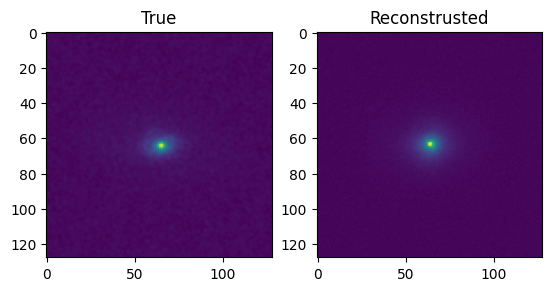

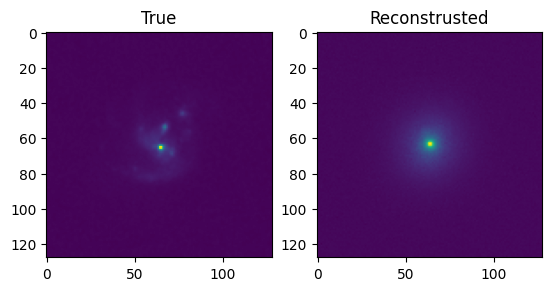

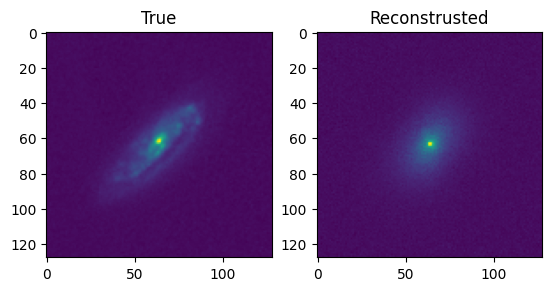

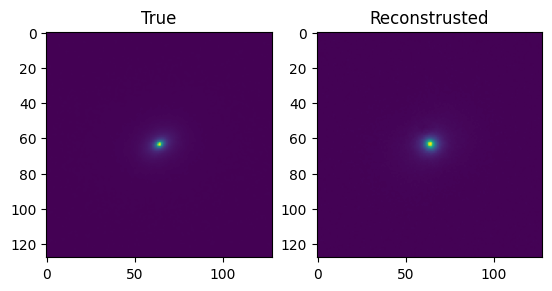

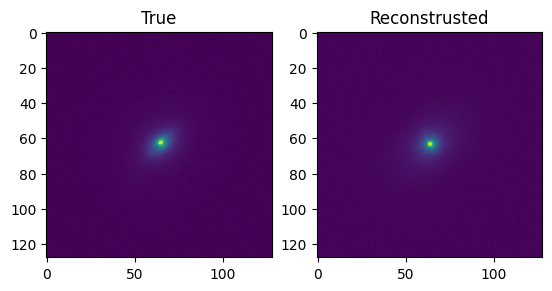

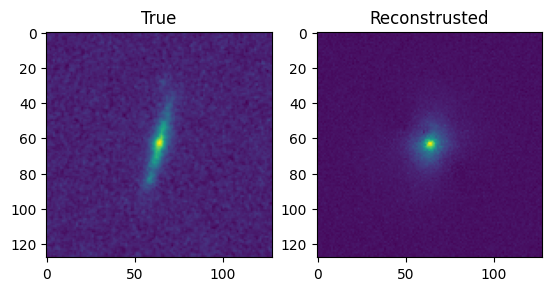

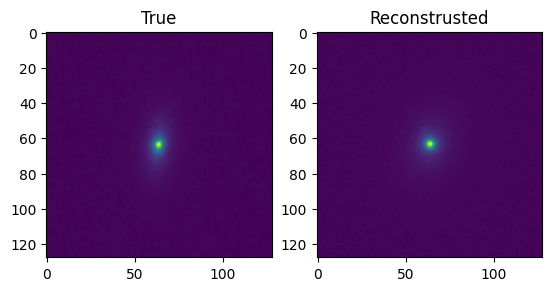

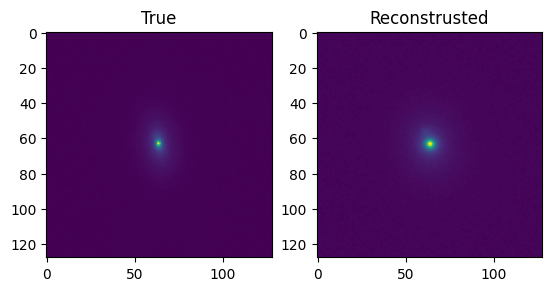

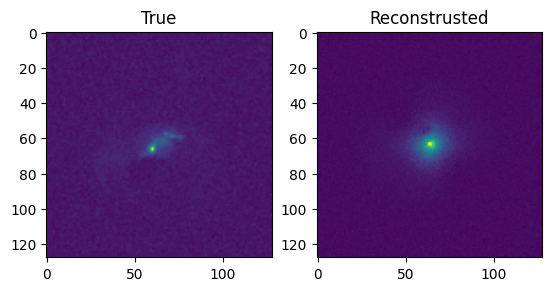

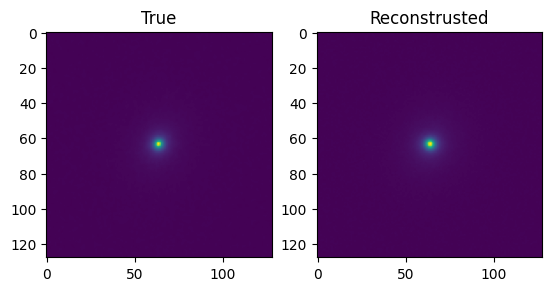

In [70]:
for i in range(10):
    fig, ax = plt.subplots(ncols=2)
    ax[0].imshow((x_batch[i]* x_std + x_mean))
    ax[1].imshow((recon_x[i]* x_std + x_mean).reshape(n_pixels, n_pixels) )
    ax[0].set_title('True')
    ax[1].set_title('Reconstrusted')
    plt.show()

## Generating samples

In [71]:
@jax.jit
def eval(params, z):
    """ Generate sample for a latent code z.
    """
    def eval_model(vae):
        return vae.decoder(z)
    return nn.apply(eval_model, vae)(params)

z = jax.random.normal(key, shape=(16, num_latents))
x_samples = eval(params, z)

# Draw samples from model
if not convolutional:
    x_samples = rearrange(x_samples, 'b (h w c) -> b h w c', h=n_pixels, w=n_pixels, c=1)

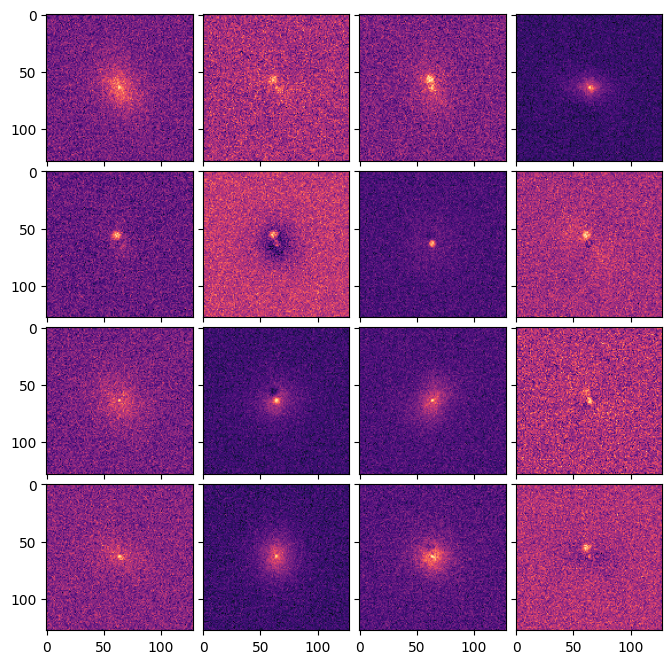

In [72]:
from mpl_toolkits.axes_grid1 import ImageGrid

fig = plt.figure(figsize=(8., 8.))

grid = ImageGrid(fig, 111, nrows_ncols=(4, 4),axes_pad=0.1,)

for ax, im in zip(grid, x_samples[..., 0]):
    ax.imshow(im, cmap='magma')

In [ ]:
# find low likelihood images vs high likelihood images

In [ ]:
# exploring latent space : plot images on map, show how to find nearest neighbors, can also compare distributions (different redshifts, sims vs data, etc...)

In [ ]:
# how good is your model? Train classifier to distinguish real from generated

In [ ]:
p = dist.MixtureSameFamily(
    mixture_distribution=dist.Categorical(probs=np.array([0.5, 0.5])),
    components_distribution=dist.Normal(
        loc=np.array([-0.2, 1]), scale=np.array([0.4, 0.5])  # One for each component.
    ),
)

In [ ]:
x = np.linspace(-5.0, 5.0, 100)
plt.plot(x, p.prob(x), label="p(x)", color="C0")

In [ ]:
q = dist.Normal(loc=0.0, scale=1.0)
plt.plot(x, p.prob(x), label="p(x)", color="C0")
plt.plot(x, q.prob(x), label="q(x)", color="C1")
plt.legend()

In [ ]:
dist.kl_divergence(p, q)

In [ ]:
def kl_via_sampling(p, q, n_samples=1000):
    key = jax.random.PRNGKey(1)
    # Get samples from q
    sample_set = q.sample(
        seed=key,
        sample_shape=[
            n_samples,
        ],
    )
    # Use the definition of KL-divergence
    return np.mean(q.log_prob(sample_set) - p.log_prob(sample_set))

In [ ]:

klv = kl_via_sampling(p, q)

In [ ]:
plt.plot(x, p.prob(x), label="p(x)", lw=4)


out = {}
for loc in [-1.0, 0.0, 1.0]:
    out[loc] = {}
    for scale in [0.5, 1.0]:
        q_loc_scale = dist.Normal(loc=loc, scale=scale)
        out[loc][scale] = kl_via_sampling(p, q_loc_scale)
        plt.plot(
            x,
            q_loc_scale.prob(x),
            label=f"Loc: {loc} Scale: {scale} D_KL:{out[loc][scale]:0.1f}",
            ls="--",
        )

plt.legend(bbox_to_anchor=(1.04, 1), loc="upper left")